# Data Scientist Case Study: Direct Marketing Optimization

## Objective
Maximize revenue from direct marketing campaigns using the provided dummy data.
Business Context: This case study simulates a real-world marketing scenario aimed at optimizing resource allocation to maximize revenue.

## Data Description
You will work with several datasets (see attached) containing the following information:
- Social-Demographic Information: Age, gender, and bank tenure.
- Product Holdings and Volumes: Details on current accounts, savings accounts, mutual funds, overdrafts, credit cards, and consumer loans.
- Financial Transactions: Aggregated inflow/outflow on current accounts and average monthly card turnover over the past three months.
- Sales and Revenue Data: Available for 60% of ccients, serving as a training set.

## Constraints
- Contact Limitation: The bank can reach out to only 15% of ccients (approximately 100 individuals).
- Single Offer Per Client: Each client can receive only one marketing offer. For example, a client might receive an offer for a consumer loan, a new credit card, or an investment in mutual funds based on their profile and financial behavior.

## Task Breakdown
1. Create Analytical Datasets: Prepare both train and test datasets using the provided data.
2. Develop Propensity Models: Build three models to estimate the likelihood of purchase for:
- a. Consumer Loan
- b. Credit Card
- c. Mutual Fund
3. Optimize Targeting Strategy: Select clients to target with marketing offers to maximize revenue, adhering to the constraints. Clearly document your approach.

# Code and Output

## 0.Setup

In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [3]:
# Set directories
os.getcwd()
work_dir = '/Users/fangzhou/Documents/Github/CaseStudy-DirectMarketingOptimisation'
os.chdir(work_dir)
os.getcwd()

'/Users/fangzhou/Documents/GitHub/CaseStudy-DirectMarketingOptimisation'

In [4]:
data_dir = work_dir+'/Data/'

## 1. Load Data

In [5]:
# Load the dataset to inspect its structure and content
data_path = data_dir + 'DataScientist_CaseStudy_Dataset.xlsx'
data = pd.ExcelFile(data_path)

## 2. Exploratory Data Analysis

The excel file contains 5 sheets. The 'Description' sheet provides the name of data sheet, variable, and description. The other 4 sheets provide four types of datasets. The "Soc_Dem" sheet contains social-demographic information. The "Products_ActBalance" sheet provides information on product holdings and account balances. The "Inflow_Outflow" sheet includes aggregated financial transaction data. The "Sales_Revenues" sheet provides target variables, indicating sales status, and revenue information for clients. 
- Sale_CL, Sale_CC, Sale_MF: Binary indicators (1 = product sold, 0 = not sold) for Consumer Loans, Credit Cards, and Mutual Funds, respectively.
- Revenue_CL, Revenue_CC, Revenue_MF: Revenue generated from each catetory of product sales.

The common variable of the 4 datasets is 'Client', i.e., Client ID. By merging the 4 datasets by Client ID, we obtain a full dataset with 1615 entries and 36 columns. Here are some key observations:
- The dataset has a mix of integer, float, and categorical values.
- Some columns named as Count_*, ActBal_*, Volume_*, and Transaction_* contain missing values. The categorical column of Sex contains a few missing values.
- The target variables, indicating sales status and revenue information for clients, contain 60% non-missing values (served as a model development set) and 40% missing values (served as a model prediction set).
- The columns, like Count_OVD and Count_CC, have a standard deviation of zero initially. After filling missing values with zero, the standard deviation is non-zero.

Data preprocessing (e.g., reformat data types, handle missing values) is conducted to prepare and clean the merged dataset. Then, the processed dataset is split into the model development set and the model prediction set based on the presence of target variables. 

The visualization is also conducted on the model development set to explore the relationship between each target variable and feature.

In [6]:
# Display sheet names to understand the structure of the file
sheet_names_list = data.sheet_names
sheet_names_list

['Description',
 'Soc_Dem',
 'Products_ActBalance',
 'Inflow_Outflow',
 'Sales_Revenues']

In [7]:
# Load all sheets into separate DataFrames for exploration

description_df = data.parse('Description')
soc_dem_df = data.parse('Soc_Dem')
products_actbalance_df = data.parse('Products_ActBalance')
inflow_outflow_df = data.parse('Inflow_Outflow')
sales_revenues_df = data.parse('Sales_Revenues')

In [8]:
# Display the description data frame
description_df

,Sheet,Variable,Description
0,Soc_Dem,Client,client ID
1,NaN,Sex,gender
2,NaN,Age,age [years]
3,NaN,Tenure,tenure with the bank [months]
4,Products_ActBalance,Client,client ID
5,NaN,Count_CA,number of live current accounts
6,NaN,Count_SA,number of live saving accounts
7,NaN,Count_MF,number of live mutual funds
8,NaN,Count_OVD,number of live overdrafts
9,NaN,Count_CC,number of live credit cards


In [9]:
# Display a sample of other data frame
soc_dem_df.head()

,Client,Sex,Age,Tenure
0,909,M,21,27
1,1217,M,38,165
2,850,F,49,44
3,1473,M,54,34
4,1038,M,29,106


In [10]:
products_actbalance_df.head()

,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,1,1,NaN,NaN,1.0,NaN,NaN,1333.802857,NaN,NaN,0.0,NaN,NaN
1,2,1,1.0,NaN,NaN,NaN,NaN,110.768571,13326.190357,NaN,NaN,NaN,NaN
2,3,1,NaN,1.0,NaN,NaN,NaN,482.654643,NaN,107.251786,NaN,NaN,NaN
3,4,1,1.0,NaN,NaN,1.0,NaN,1599.840714,76.437143,NaN,NaN,1110.381786,NaN
4,5,1,1.0,NaN,NaN,NaN,NaN,5353.483929,8079.715714,NaN,NaN,NaN,NaN


In [11]:
inflow_outflow_df.head()

,Client,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,1017,0.005000,0.005000,1,1,118.046429,118.046429,25.000000,91.796429,0.000000,12,12,2,9,0
1,1456,364.772143,364.752857,4,3,774.980000,774.980000,14.285714,497.444286,258.607143,28,28,1,20,5
2,545,2471.719286,2471.719286,14,14,2190.257143,2190.257143,303.571429,179.082143,1229.428571,23,23,3,5,12
3,667,1127.792857,1127.792857,4,4,1344.603571,1344.603571,642.857143,194.285714,249.321429,21,21,3,4,8
4,1381,571.618214,571.618214,3,3,57.071429,57.071429,10.714286,46.357143,0.000000,6,6,1,5,0


In [12]:
sales_revenues_df.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1094,0,1,0,0.000000,5.138571,0.0000
1,1484,1,0,1,25.609107,0.000000,8.7225
2,20,0,1,0,0.000000,3.822500,0.0000
3,1193,0,0,0,0.000000,0.000000,0.0000
4,142,0,0,0,0.000000,0.000000,0.0000


In [13]:
# Merge the sheets into a single dataset based on the Client ID
merged_df = soc_dem_df.merge(products_actbalance_df, on="Client", how="left")
merged_df = merged_df.merge(inflow_outflow_df, on="Client", how="left")
merged_df = merged_df.merge(sales_revenues_df, on="Client", how="left")

# Display summary of the merged dataset
merged_df.info()

# Preview a sample of the merged dataset
merged_df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1615 entries, 0 to 1614
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Client                        1615 non-null   int64  
 1   Sex                           1612 non-null   object 
 2   Age                           1615 non-null   int64  
 3   Tenure                        1615 non-null   int64  
 4   Count_CA                      1615 non-null   int64  
 5   Count_SA                      426 non-null    float64
 6   Count_MF                      306 non-null    float64
 7   Count_OVD                     419 non-null    float64
 8   Count_CC                      170 non-null    float64
 9   Count_CL                      135 non-null    float64
 10  ActBal_CA                     1615 non-null   float64
 11  ActBal_SA                     426 non-null    float64
 12  ActBal_MF                     306 non-null    float64
 13  Act

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,909,M,21,27,1,NaN,NaN,1.0,NaN,1.0,...,7.0,1.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1217,M,38,165,1,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,850,F,49,44,1,NaN,NaN,NaN,NaN,NaN,...,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000000,0.893929,0.0
3,1473,M,54,34,1,1.0,NaN,NaN,1.0,1.0,...,38.0,1.0,26.0,11.0,1.0,0.0,0.0,4.929643,0.000000,0.0
4,1038,M,29,106,1,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [14]:
#merged_df[['Sale_CL', 'Sale_CC', 'Sale_MF']] = merged_df[['Sale_CL', 'Sale_CC', 'Sale_MF']].astype('Int64')
#merged_df[['Client', 'Sale_CL', 'Sale_CC', 'Sale_MF']] =  merged_df[['Client', 'Sale_CL', 'Sale_CC', 'Sale_MF']].astype(str)
#print(merged_df.dtypes)

In [15]:
# Describe the numeric columns
cols = merged_df.columns
num_cols = cols[2:-6].tolist() + cols[-3:].tolist()
print(merged_df[num_cols].describe())

               Age       Tenure     Count_CA    Count_SA    Count_MF  \
count  1615.000000  1615.000000  1615.000000  426.000000  306.000000   
mean     42.848916   101.339938     1.078638    1.166667    4.676471   
std      18.550529    64.917297     0.333035    0.468205    7.845009   
min       0.000000     0.000000     1.000000    1.000000    1.000000   
25%      29.000000    44.000000     1.000000    1.000000    1.000000   
50%      41.000000    97.000000     1.000000    1.000000    2.000000   
75%      57.000000   151.000000     1.000000    1.000000    5.000000   
max      97.000000   273.000000     4.000000    5.000000   79.000000   

       Count_OVD  Count_CC    Count_CL      ActBal_CA      ActBal_SA  ...  \
count      419.0     170.0  135.000000    1615.000000     426.000000  ...   
mean         1.0       1.0    1.185185    2438.601941   15201.520284  ...   
std          0.0       0.0    0.520980    7072.777350   32365.183430  ...   
min          1.0       1.0    1.000000     

In [16]:
# Count values of the categorical columns and binary indicators
cat_cols = ['Sex', 'Sale_CL', 'Sale_CC', 'Sale_MF']
for col in cat_cols:
    print(merged_df[col].value_counts())

M    856
F    756
Name: Sex, dtype: int64
0.0    679
1.0    290
Name: Sale_CL, dtype: int64
0.0    727
1.0    242
Name: Sale_CC, dtype: int64
0.0    776
1.0    193
Name: Sale_MF, dtype: int64


We handle missing values by replacing NaN with zero for counts, balances, volumes, and transactions and replacing NaN with its mode for Sex.

In [17]:
# Check the number of missing values for each variable
missing_values = merged_df.isnull().sum()
missing_values[missing_values > 0]

Sex                                3
Count_SA                        1189
Count_MF                        1309
Count_OVD                       1196
Count_CC                        1445
Count_CL                        1480
ActBal_SA                       1189
ActBal_MF                       1309
ActBal_OVD                      1196
ActBal_CC                       1445
ActBal_CL                       1480
VolumeCred                        28
VolumeCred_CA                     28
TransactionsCred                  28
TransactionsCred_CA               28
VolumeDeb                         28
VolumeDeb_CA                      28
VolumeDebCash_Card                28
VolumeDebCashless_Card            28
VolumeDeb_PaymentOrder            28
TransactionsDeb                   28
TransactionsDeb_CA                28
TransactionsDebCash_Card          28
TransactionsDebCashless_Card      28
TransactionsDeb_PaymentOrder      28
Sale_MF                          646
Sale_CC                          646
S

In [18]:
# List the column names with missing values
missing_values_cols = missing_values[missing_values > 0].index.tolist()
missing_values_cols

['Sex',
 'Count_SA',
 'Count_MF',
 'Count_OVD',
 'Count_CC',
 'Count_CL',
 'ActBal_SA',
 'ActBal_MF',
 'ActBal_OVD',
 'ActBal_CC',
 'ActBal_CL',
 'VolumeCred',
 'VolumeCred_CA',
 'TransactionsCred',
 'TransactionsCred_CA',
 'VolumeDeb',
 'VolumeDeb_CA',
 'VolumeDebCash_Card',
 'VolumeDebCashless_Card',
 'VolumeDeb_PaymentOrder',
 'TransactionsDeb',
 'TransactionsDeb_CA',
 'TransactionsDebCash_Card',
 'TransactionsDebCashless_Card',
 'TransactionsDeb_PaymentOrder',
 'Sale_MF',
 'Sale_CC',
 'Sale_CL',
 'Revenue_MF',
 'Revenue_CC',
 'Revenue_CL']

In [19]:
# Handle missing values by replacing NaN with appropriate defaults (0 for counts, balances, volumes and transactions)
processed_df = merged_df
processed_df[missing_values_cols[1:-6]] = merged_df[missing_values_cols[1:-6]].fillna(0)

# Check for remaining missing values
missing_values = processed_df.isnull().sum()
missing_values[missing_values > 0]

Sex             3
Sale_MF       646
Sale_CC       646
Sale_CL       646
Revenue_MF    646
Revenue_CC    646
Revenue_CL    646
dtype: int64

In [20]:
# Handle missing values by replacing NaN with mean for numeric variables
#processed_df = merged_df
#imputer = SimpleImputer(strategy='mean')
#processed_df[missing_values_cols[1:-6]] = imputer.fit_transform(
#processed_df[missing_values_cols[1:-6]]
#)

# Check for remaining missing values
#missing_values = processed_df.isnull().sum()
#missing_values[missing_values > 0]

In [21]:
# Fill categorical missing values with the mode ('M' for Sex)
processed_df[['Sex']] = processed_df[['Sex']].fillna('M')

# Verify no missing values remain
missing_values_final = processed_df.isnull().sum()
missing_values_final[missing_values_final > 0]

Sale_MF       646
Sale_CC       646
Sale_CL       646
Revenue_MF    646
Revenue_CC    646
Revenue_CL    646
dtype: int64

The processed dataset is splitted into the model development set and the model prediction set based on the presence of target variables.

In [22]:
# Split into training and testing sets based on the presence of sales/revenue data
train_df = processed_df[(processed_df['Sale_MF'] >= 0) | 
                            (processed_df['Sale_CC'] >= 0) | 
                            (processed_df['Sale_CL'] >= 0)]
test_df = processed_df[~((processed_df['Sale_MF'] >= 0) | 
                            (processed_df['Sale_CC'] >= 0) | 
                            (processed_df['Sale_CL'] >= 0))]

# Check the sizes of the training and testing datasets
train_size = train_df.shape[0]
test_size = test_df.shape[0]

train_size, test_size


(969, 646)

We conduct data visualization to explore the relationships between each target variable and features. Below are some example.

In [23]:
# Define target variables
target_cols = ['Sale_CL', 'Sale_CC', 'Sale_MF']

# Define features
feature_cols = train_df.drop(columns = target_cols + ['Client', 'Revenue_CL', 'Revenue_CC', 'Revenue_MF']).columns.tolist()
cat_feature_cols = ['Sex']
num_feature_cols = list(set(feature_cols)-set(cat_feature_cols))

Barplot is used to visualize the distribution of each target variable.

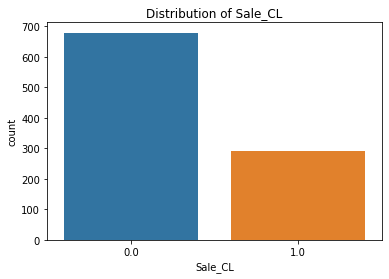

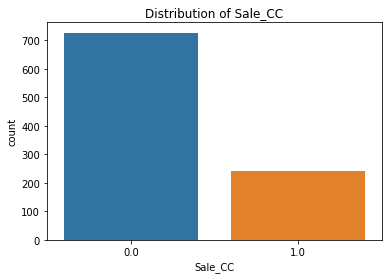

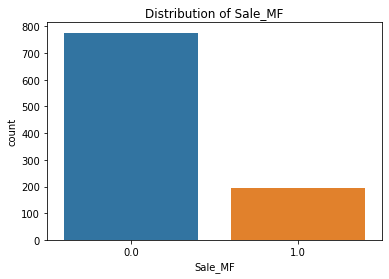

In [24]:
# Visualize the Target Variable Distribution

for col in target_cols:
    sns.countplot(train_df[col])
    plt.title(f'Distribution of {col}')
    plt.show()

Histogram and Boxplot of numerical feature by sales status of product are used to detect the pattern and relationship between sales status of product and each numerical feature.

For example, the histogram and boxplot of Tenure by Sale_CL show that clients with a higher tenure are more likely to purchase a consumer loan.

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


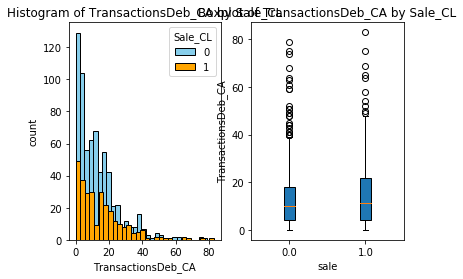

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


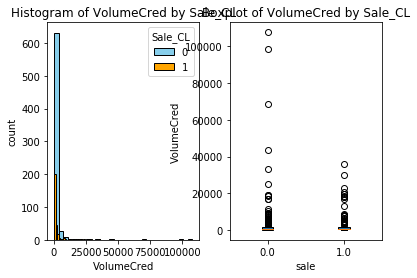

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


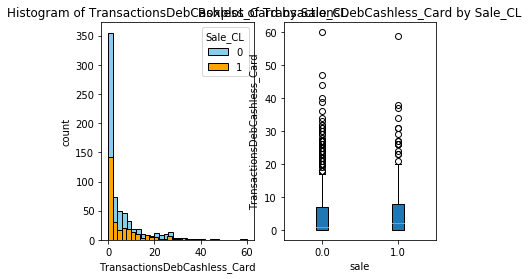

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


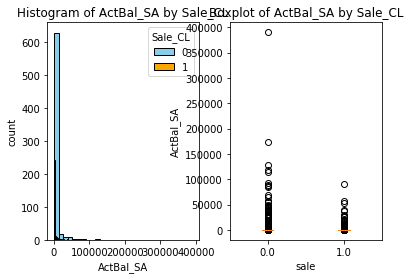

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


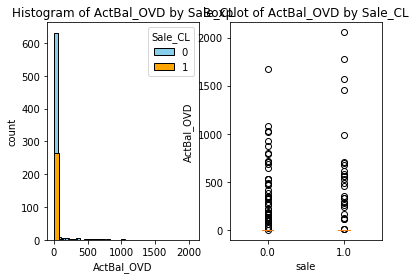

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


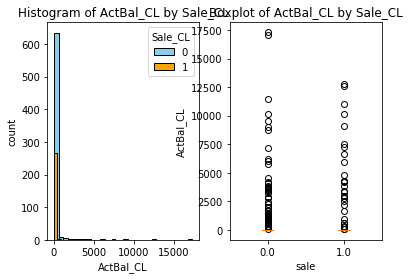

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


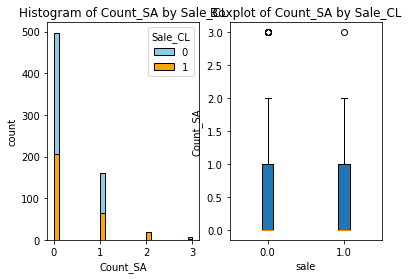

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


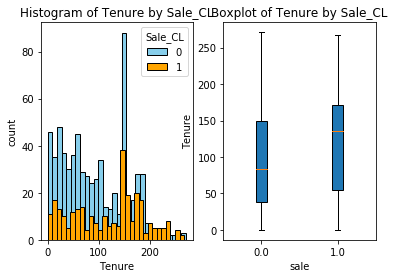

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


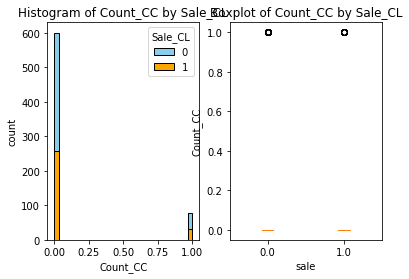

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


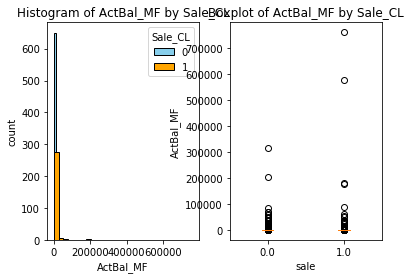

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


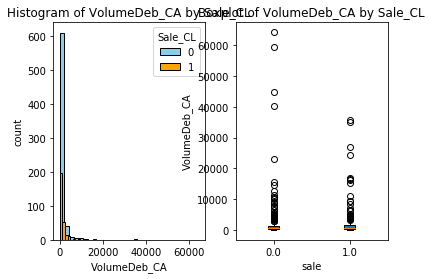

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


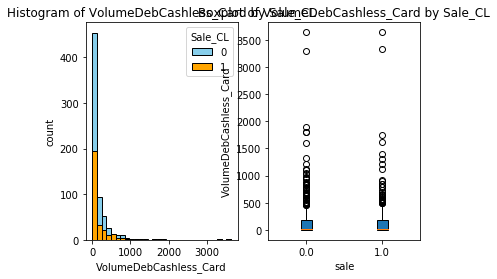

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


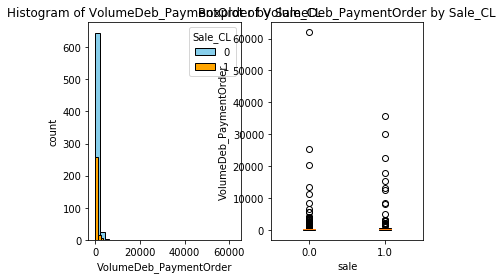

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


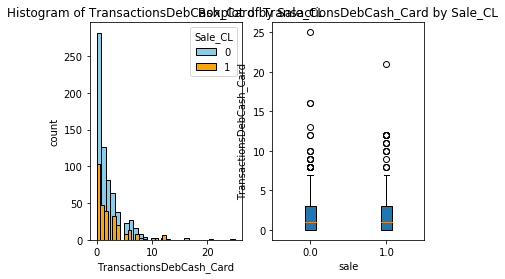

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


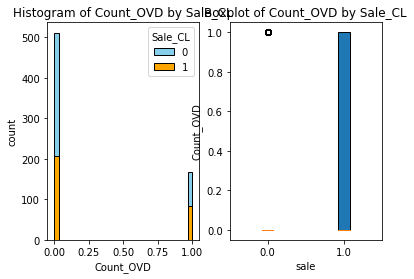

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


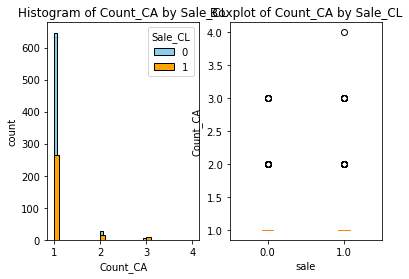

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


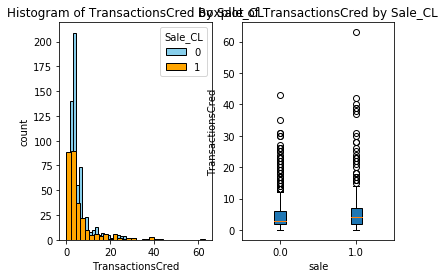

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


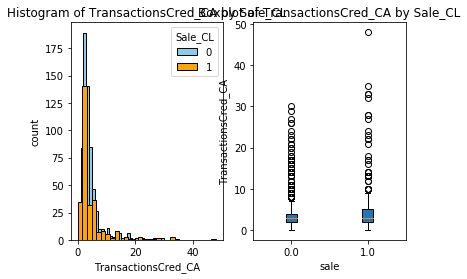

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


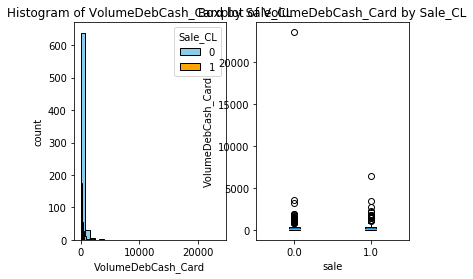

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


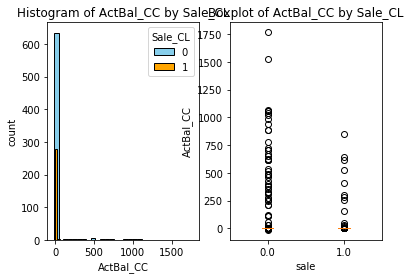

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


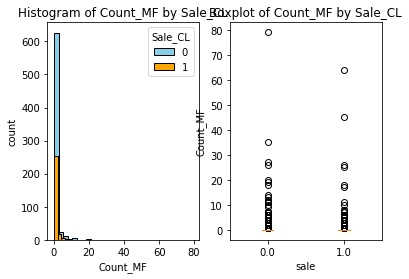

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


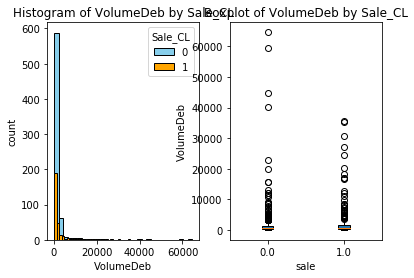

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


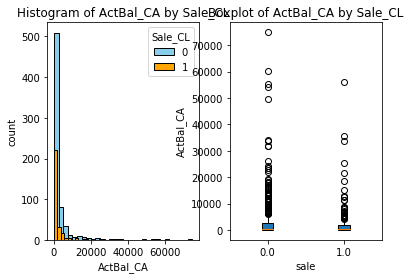

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


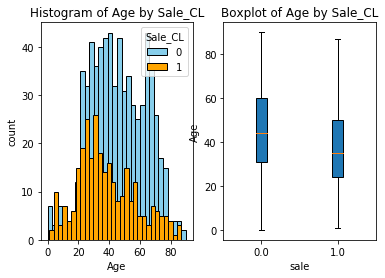

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


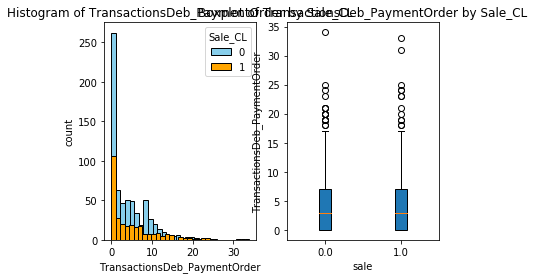

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


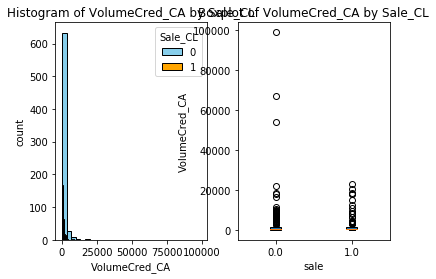

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


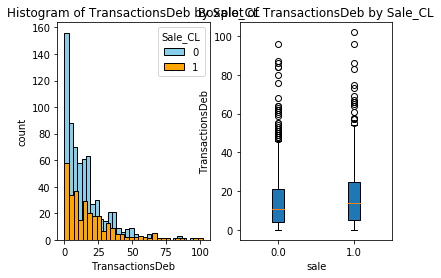

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


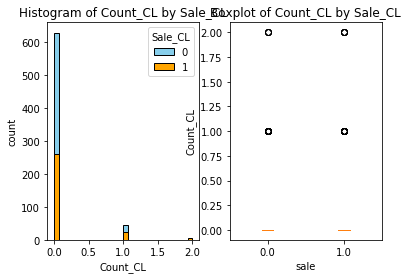

In [25]:
# Visualize Numerical Variables Distribution by Target

for col in num_feature_cols: 
    not_sold = train_df.loc[train_df['Sale_CL'] == 0, col]
    sold = train_df.loc[train_df['Sale_CL'] == 1, col]
    figure, (ax1, ax2) = plt.subplots(1, 2)
    ax1.hist(not_sold, bins=30, color='skyblue', edgecolor='black', label='0')
    ax1.hist(sold, bins=30, color='orange', edgecolor='black', label='1')
    ax1.set_title(f'Histogram of {col} by Sale_CL')
    ax1.set_xlabel(col)
    ax1.set_ylabel('count')
    ax1.legend(title='Sale_CL')
    sales = train_df['Sale_CL'].unique()
    grouped_data = [train_df[train_df['Sale_CL'] == sale][col] for sale in sales]
    ax2.boxplot(grouped_data, labels=sales, patch_artist=True)
    ax2.set_xlabel('sale')
    ax2.set_ylabel(col)
    ax2.set_title(f'Boxplot of {col} by Sale_CL')
    plt.show()


The stacked bar plots, showing the percentage distribution of sales status of product by categorical feature, are used to detect the patterns and relationship between sales status of product and each categorical feature.

For example, the stacked bar plot of Sale_CL by Sex show that the clients with Sex equal to female are more likely to purchase a consumer loan.

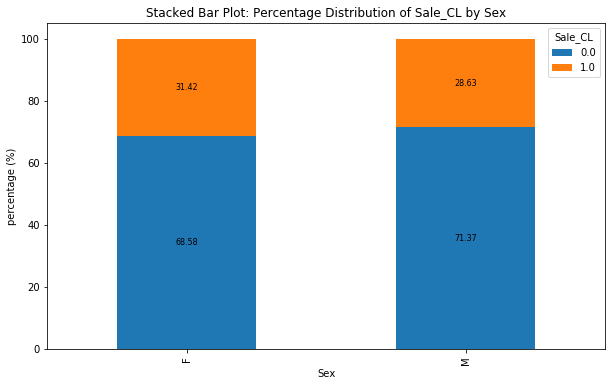

In [26]:
# Visualize Event Distribution by Categorical Variable

for col in cat_feature_cols:
    grouped = train_df.groupby([col, 'Sale_CL']).size().unstack(fill_value=0)
    grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100
    #grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
    ax = grouped_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
    # .patches is everything inside of the chart
    for rect in ax.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()
        # The height of the bar is the data value and can be used as the label
        label_text = f'{round(height, 2)}'  # f'{height:.2f}' to format decimal values
        # ax.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2
        # plot only when height is greater than specified value
        if height > 0:
            ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=8)
    plt.title(f'Stacked Bar Plot: Percentage Distribution of Sale_CL by {col}')
    plt.xlabel(col)
    plt.ylabel('percentage (%)')
    plt.legend(title='Sale_CL', loc='upper right')
    plt.show()

## 3. Data Preprocessing for Modeling

By conducting the exploratory data analysis, we get a rough idea about which factors are more likely to contribute to the product purchase by clients.

To be more quatitative and scientific, machine learning model will be used to further detect the patterns.

Before building the model, we need to preprocess the data, including but not limited to feature scaling and categorical variable encoding.

In [27]:
# Define target variables
target_cols = ['Sale_CL', 'Sale_CC', 'Sale_MF']

# Define features
feature_cols = train_df.drop(columns = target_cols + ['Client', 'Revenue_CL', 'Revenue_CC', 'Revenue_MF']).columns.tolist()
cat_feature_cols = ['Sex']
num_feature_cols = list(set(feature_cols)-set(cat_feature_cols))
print(feature_cols)
print(cat_feature_cols)
print(num_feature_cols)

['Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']
['Sex']
['TransactionsDeb_CA', 'VolumeCred', 'TransactionsDebCashless_Card', 'ActBal_SA', 'ActBal_OVD', 'ActBal_CL', 'Count_SA', 'Tenure', 'Count_CC', 'ActBal_MF', 'VolumeDeb_CA', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDebCash_Card', 'Count_OVD', 'Count_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDebCash_Card', 'ActBal_CC', 'Count_MF', 'VolumeDeb', 'ActBal_CA', 'Age', 'TransactionsDeb_PaymentOrder', 'VolumeCred_CA', 'TransactionsDeb', 'Count_CL']


In [28]:
# Scaling numeric features
scaler = StandardScaler()
train_df[num_feature_cols] = scaler.fit_transform(
train_df[num_feature_cols]
)

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [29]:
# Encode categorical features
train_df = pd.get_dummies(train_df, columns=cat_feature_cols, drop_first=True)

In [30]:
train_df.columns

Index(['Client', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'Sale_MF', 'Sale_CC', 'Sale_CL',
       'Revenue_MF', 'Revenue_CC', 'Revenue_CL', 'Sex_M'],
      dtype='object')

## 4. Model Development and Evaluation

Once the processed model development data is ready, we build three machine learning models for binary classification using algorithm like random forest to estimate the likelihood of purchase for:
- Consumer Loan
- Credit Card
- Mutual Fund

The model performance evaluation results are as shown in the below table.

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Model</th>
      <th>AUC</th>
      <th>Accuracy</th>
      <th>Precision</th>
      <th>Recall</th>
      <th>F1-Score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>rf_cl</td>
      <td>0.553237</td>
      <td>0.706186</td>
      <td>0.599755</td>
      <td>0.553237</td>
      <td>0.547007</td>
    </tr>
    <tr>
      <th>1</th>
      <td>rf_cc</td>
      <td>0.474526</td>
      <td>0.675258</td>
      <td>0.456863</td>
      <td>0.474526</td>
      <td>0.456969</td>
    </tr>
    <tr>
      <th>2</th>
      <td>rf_mf</td>
      <td>0.506111</td>
      <td>0.731959</td>
      <td>0.539007</td>
      <td>0.506111</td>
      <td>0.457401</td>
    </tr>
  </tbody>
</table>
</div>

The feature importances are also calculated from the three models. The visualization graphs show top important factors contributing to the purchase of each product.



In [31]:
# Re-define features
features =  train_df.drop(columns = target_cols + ['Client', 'Revenue_CL', 'Revenue_CC', 'Revenue_MF'])
features

,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,...,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sex_M
1,-0.268372,0.987822,-0.23277,-0.558701,-0.216405,-0.591255,-0.357849,-0.285555,0.679866,-0.216816,...,-0.175860,-0.307071,-0.468059,0.002705,-0.920847,-0.965795,-0.734711,-0.631917,-0.678557,1
2,0.324002,-0.862237,-0.23277,-0.558701,-0.216405,-0.591255,-0.357849,-0.285555,-0.390995,-0.216816,...,-0.057686,-0.307071,-0.468059,-0.190312,-0.615160,-0.581460,-0.734711,-0.631917,-0.678557,0
3,0.593263,-1.015135,-0.23277,1.170951,-0.216405,-0.591255,2.794475,2.858793,-0.393309,0.577095,...,0.535014,0.105430,0.876240,0.446670,1.952613,1.878283,-0.363912,2.490978,1.236184,1
4,-0.753041,0.085727,-0.23277,-0.558701,-0.216405,-0.591255,-0.357849,-0.285555,-0.393627,-0.216816,...,-0.340703,-0.307071,-0.468059,-0.230042,-0.981985,-1.042662,-0.734711,-0.631917,-0.870032,1
5,-1.560823,1.324196,-0.23277,-0.558701,-0.216405,1.691318,-0.357849,-0.285555,-0.342763,-0.216816,...,-0.310581,-0.307071,-0.131723,-0.223758,-0.676298,-0.658327,-0.734711,-0.151472,-0.678557,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607,-0.322224,0.789055,-0.23277,1.170951,-0.216405,-0.591255,-0.357849,-0.285555,-0.198461,-0.216816,...,-0.340703,-0.307071,-0.468059,-0.230042,-0.920847,-1.042662,-0.734711,-0.631917,-0.870032,0
1609,-0.806893,0.682027,-0.23277,-0.558701,-0.216405,-0.591255,-0.357849,6.003141,1.823348,-0.216816,...,-0.304907,-0.265821,-0.468059,-0.230042,-0.615160,-0.735194,-0.363912,-0.631917,-0.870032,1
1611,-1.076154,0.911373,-0.23277,-0.558701,-0.216405,-0.591255,-0.357849,-0.285555,-0.011836,-0.216816,...,-0.320292,-0.249321,-0.355058,-0.229693,-0.492885,-0.427726,0.006888,-0.031360,-0.678557,1
1612,0.162446,-0.632891,-0.23277,-0.558701,-0.216405,-0.591255,-0.357849,-0.285555,0.023350,-0.216816,...,-0.323140,-0.220446,-0.464830,-0.230030,-0.737435,-0.735194,0.006888,-0.511806,-0.678557,1


In [32]:
# Prepare input (X) and target (y) datasets for each product type
X = features
y_cl = train_df['Sale_CL']
y_cc = train_df['Sale_CC']
y_mf = train_df['Sale_MF']

# Split model development data further into a training set and a validation set for each target (CL, CC, MF)
X_train_cl, X_val_cl, y_train_cl, y_val_cl = train_test_split(X, y_cl, test_size=0.2, random_state=42)
X_train_cc, X_val_cc, y_train_cc, y_val_cc = train_test_split(X, y_cc, test_size=0.2, random_state=42)
X_train_mf, X_val_mf, y_train_mf, y_val_mf = train_test_split(X, y_mf, test_size=0.2, random_state=42)

# Verify the shapes of the prepared datasets
X_train_cl.shape, X_val_cl.shape, X_train_cc.shape, X_val_cc.shape, X_train_mf.shape, X_val_mf.shape


((775, 29), (194, 29), (775, 29), (194, 29), (775, 29), (194, 29))

In [39]:
# Define result list
result_list = []

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/fangzhou/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/Users/fangzhou/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a depreca

Model Name: rf_cl, ROC AUC Score: 0.5532, Accuracy: 0.7062, Precision: 0.5998, Recall: 0.5532, F1 Score: 0.5470
Model Name: rf_cl, Classification Report: 
               precision    recall  f1-score   support

         0.0       0.74      0.91      0.82       139
         1.0       0.46      0.20      0.28        55

    accuracy                           0.71       194
   macro avg       0.60      0.55      0.55       194
weighted avg       0.66      0.71      0.66       194



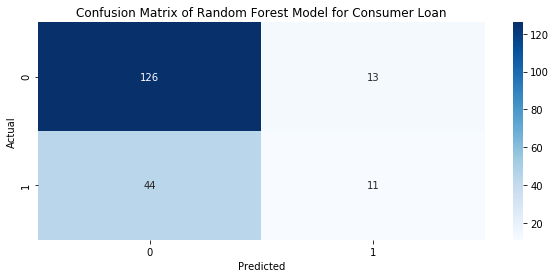

                         Feature  Importance
0                            Age    0.113886
1                         Tenure    0.106436
14                    VolumeCred    0.062894
18                     VolumeDeb    0.062257
22        VolumeDeb_PaymentOrder    0.059682
8                      ActBal_CA    0.052880
15                 VolumeCred_CA    0.052553
19                  VolumeDeb_CA    0.046932
23               TransactionsDeb    0.043025
17           TransactionsCred_CA    0.039137
24            TransactionsDeb_CA    0.037956
20            VolumeDebCash_Card    0.036928
27  TransactionsDeb_PaymentOrder    0.034925
21        VolumeDebCashless_Card    0.030000
9                      ActBal_SA    0.029594
16              TransactionsCred    0.028488
25      TransactionsDebCash_Card    0.027272
26  TransactionsDebCashless_Card    0.023323
2                       Count_CA    0.013515
13                     ActBal_CL    0.013345
4                       Count_MF    0.012375
12        

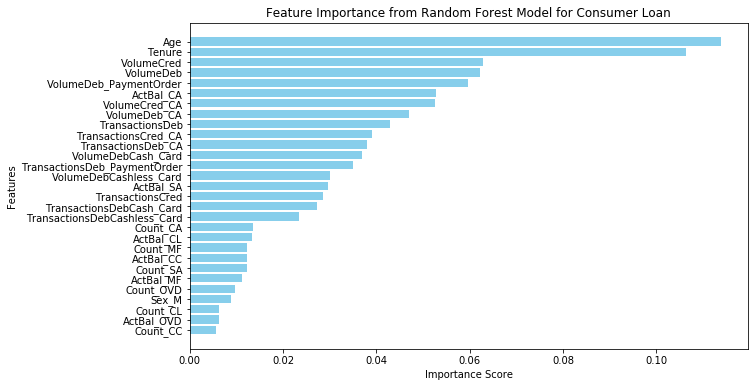

In [40]:
# Train Random Forest models for each target

# Fit Consumer Loan model
rf_cl = RandomForestClassifier(random_state=42)
rf_cl.fit(X_train_cl, y_train_cl)

# Evaluate Consumer Loan model
y_val_pred_cl = rf_cl.predict(X_val_cl)
y_val_prob_cl = rf_cl.predict_proba(X_val_cl)[:, 1]

model_name = 'rf_cl'
auc = roc_auc_score(y_val_cl, y_val_pred_cl)
accuracy = accuracy_score(y_val_cl, y_val_pred_cl)
precision = precision_score(y_val_cl, y_val_pred_cl, average='macro')
recall = recall_score(y_val_cl, y_val_pred_cl, average='macro')
f1 = f1_score(y_val_cl, y_val_pred_cl, average='macro')

print(f"Model Name: {model_name}, ROC AUC Score: {auc:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
print(f"Model Name: {model_name}, Classification Report: \n {classification_report(y_val_cl, y_val_pred_cl)}")

cm = confusion_matrix(y_val_cl, y_val_pred_cl)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Random Forest Model for Consumer Loan')
plt.show()

# Obtain feature importances
feature_importances = rf_cl.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print feature importances
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest Model for Consumer Loan')
plt.gca().invert_yaxis()  # Invert axis to display highest importance at the top
plt.show()

# Save model evaluation result
result_list.append([model_name, auc, accuracy, precision, recall, f1])


Model Name: rf_cc, ROC AUC Score: 0.4745, Accuracy: 0.6753, Precision: 0.4569, Recall: 0.4745, F1 Score: 0.4570
Model Name: rf_cc, Classification Report: 
               precision    recall  f1-score   support

         0.0       0.74      0.91      0.82       139
         1.0       0.46      0.20      0.28        55

    accuracy                           0.71       194
   macro avg       0.60      0.55      0.55       194
weighted avg       0.66      0.71      0.66       194



/Users/fangzhou/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/fangzhou/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/Users/fangzhou/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a depreca

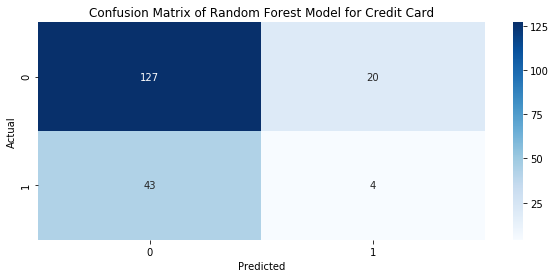

                         Feature  Importance
8                      ActBal_CA    0.108644
9                      ActBal_SA    0.074093
14                    VolumeCred    0.067796
1                         Tenure    0.065613
15                 VolumeCred_CA    0.063030
18                     VolumeDeb    0.057958
22        VolumeDeb_PaymentOrder    0.057197
19                  VolumeDeb_CA    0.051891
0                            Age    0.050910
25      TransactionsDebCash_Card    0.039474
23               TransactionsDeb    0.038633
16              TransactionsCred    0.035599
24            TransactionsDeb_CA    0.034040
26  TransactionsDebCashless_Card    0.033856
27  TransactionsDeb_PaymentOrder    0.033202
20            VolumeDebCash_Card    0.032990
21        VolumeDebCashless_Card    0.028739
17           TransactionsCred_CA    0.027600
12                     ActBal_CC    0.015684
5                      Count_OVD    0.012909
2                       Count_CA    0.011392
3         

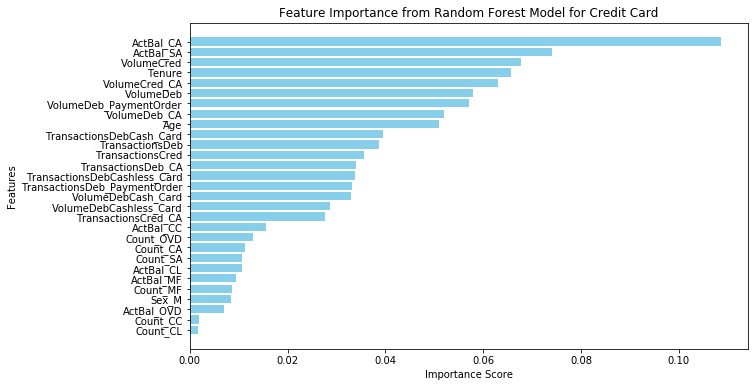

In [41]:

# Train Random Forest models for each target

# Fit Credit Card model
rf_cc = RandomForestClassifier(random_state=42)
rf_cc.fit(X_train_cc, y_train_cc)

# Evaluate Credit Card model
y_val_pred_cc = rf_cl.predict(X_val_cc)
y_val_prob_cc = rf_cl.predict_proba(X_val_cc)[:, 1]

model_name = 'rf_cc'
auc = roc_auc_score(y_val_cc, y_val_pred_cc)
accuracy = accuracy_score(y_val_cc, y_val_pred_cc)
precision = precision_score(y_val_cc, y_val_pred_cc, average='macro')
recall = recall_score(y_val_cc, y_val_pred_cc, average='macro')
f1 = f1_score(y_val_cc, y_val_pred_cc, average='macro')

print(f"Model Name: {model_name}, ROC AUC Score: {auc:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
print(f"Model Name: {model_name}, Classification Report: \n {classification_report(y_val_cl, y_val_pred_cl)}")

cm = confusion_matrix(y_val_cc, y_val_pred_cc)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Random Forest Model for Credit Card')
plt.show()

# Obtain feature importances
feature_importances = rf_cc.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print feature importances
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest Model for Credit Card')
plt.gca().invert_yaxis()  # Invert axis to display highest importance at the top
plt.show()

# Save model evaluation result
result_list.append([model_name, auc, accuracy, precision, recall, f1])

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/fangzhou/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/Users/fangzhou/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a depreca

Model Name: rf_mf, ROC AUC Score: 0.5061, Accuracy: 0.7320, Precision: 0.5390, Recall: 0.5061, F1 Score: 0.4574
Model Name: rf_mf, Classification Report: 
               precision    recall  f1-score   support

         0.0       0.74      0.91      0.82       139
         1.0       0.46      0.20      0.28        55

    accuracy                           0.71       194
   macro avg       0.60      0.55      0.55       194
weighted avg       0.66      0.71      0.66       194



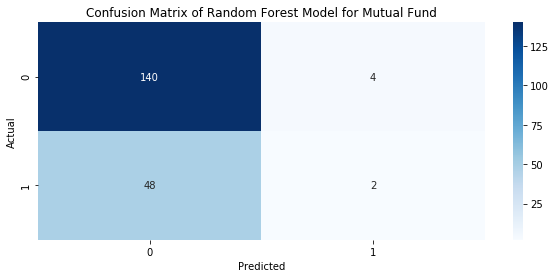

                         Feature  Importance
8                      ActBal_CA    0.070399
1                         Tenure    0.069871
15                 VolumeCred_CA    0.069081
0                            Age    0.060440
18                     VolumeDeb    0.060191
14                    VolumeCred    0.056556
4                       Count_MF    0.052927
24            TransactionsDeb_CA    0.052015
26  TransactionsDebCashless_Card    0.050065
16              TransactionsCred    0.048155
19                  VolumeDeb_CA    0.047653
22        VolumeDeb_PaymentOrder    0.044042
23               TransactionsDeb    0.043211
20            VolumeDebCash_Card    0.036676
17           TransactionsCred_CA    0.035023
21        VolumeDebCashless_Card    0.031627
27  TransactionsDeb_PaymentOrder    0.029517
9                      ActBal_SA    0.027327
10                     ActBal_MF    0.025486
12                     ActBal_CC    0.021410
25      TransactionsDebCash_Card    0.019231
11        

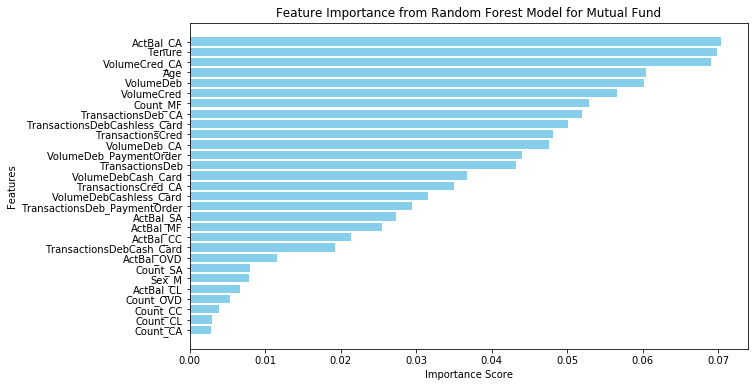

In [42]:

# Train Random Forest models for each target

# Fit Credit Card model
rf_mf = RandomForestClassifier(random_state=42)
rf_mf.fit(X_train_mf, y_train_mf)

# Evaluate Credit Card model
y_val_pred_mf = rf_mf.predict(X_val_mf)
y_val_prob_mf = rf_mf.predict_proba(X_val_mf)[:, 1]

model_name = 'rf_mf'
auc = roc_auc_score(y_val_mf, y_val_pred_mf)
accuracy = accuracy_score(y_val_mf, y_val_pred_mf)
precision = precision_score(y_val_mf, y_val_pred_mf, average='macro')
recall = recall_score(y_val_mf, y_val_pred_mf, average='macro')
f1 = f1_score(y_val_mf, y_val_pred_mf, average='macro')

print(f"Model Name: {model_name}, ROC AUC Score: {auc:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
print(f"Model Name: {model_name}, Classification Report: \n {classification_report(y_val_cl, y_val_pred_cl)}")

cm = confusion_matrix(y_val_mf, y_val_pred_mf)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Random Forest Model for Mutual Fund')
plt.show()

# Obtain feature importances
feature_importances = rf_mf.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print feature importances
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest Model for Mutual Fund')
plt.gca().invert_yaxis()  # Invert axis to display highest importance at the top
plt.show()

# Save model evaluation result
result_list.append([model_name, auc, accuracy, precision, recall, f1])

In [43]:
# Summarize evaluation result
evaluate_result_df = pd.DataFrame(result_list, columns=['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
evaluate_result_df

,Model,AUC,Accuracy,Precision,Recall,F1-Score
0,rf_cl,0.553237,0.706186,0.599755,0.553237,0.547007
1,rf_cc,0.474526,0.675258,0.456863,0.474526,0.456969
2,rf_mf,0.506111,0.731959,0.539007,0.506111,0.457401


## 5. Model Prediction and Target Strategy Optimisation

After building the three models on the model development set, we utilize them to predict the likelihood of purchase for each product on the model prediction set, respectively. 

Then, we obtain the maximum probability of purchase for a product and the corresponding top product for each client to answer the question which product is more likely to be purchased by each client across the three products.

We could also rank and select the top 15% of clients based on the probability of purchase to answer the question which clients have a higher propensity of purchase for consumer loan, credit card and mutual fund respectively.

Further, we could calculate the expected revenues by multiplying the probability of purchase for each product with the average revenue for the corresponding product sale. By ranking expected revenues generated from each product sale for each client, we can obtain the maximum expected revenue and the corresponding product offer for each client.

Under the constraint that only 15% of clients can be targetted, we could select the top 15% of clients who have a higher maximum expected revenue for targetting with the corresponding product offer.

By summing up the maximum expected revenues of the top 15% of clients, we can obtain the expected revenue based on our strategy.

The corresponding code and result are displayed below.



In [44]:
# Scaling numeric features
scaler = StandardScaler()
test_df[num_feature_cols] = scaler.fit_transform(
test_df[num_feature_cols]
)

/Users/fangzhou/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [45]:
# Encode categorical features
test_df = pd.get_dummies(test_df, columns=cat_feature_cols, drop_first=True)

In [46]:
test_df.columns

Index(['Client', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'Sale_MF', 'Sale_CC', 'Sale_CL',
       'Revenue_MF', 'Revenue_CC', 'Revenue_CL', 'Sex_M'],
      dtype='object')

In [47]:
# Re-define features
features_test =  test_df.drop(columns = target_cols + ['Client', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL'])
features_test

,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,...,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sex_M
0,-1.169730,-1.181825,-0.241360,-0.517639,-0.291644,1.686783,-0.319983,2.134198,-0.289322,-0.23528,...,-0.224579,-0.105004,-0.503203,-0.158858,-0.451054,-0.468346,-0.338127,-0.596200,-0.094430,1
6,-0.305147,1.126912,-0.241360,-0.517639,1.284943,1.686783,-0.319983,-0.267704,-0.065670,-0.23528,...,-0.196082,-0.271530,-0.503203,-0.143870,-0.139150,-0.236328,0.032093,-0.596200,0.099226,1
9,-1.277803,-0.511043,-0.241360,-0.517639,-0.291644,1.686783,-0.319983,-0.267704,-0.289902,-0.23528,...,-0.238882,-0.204920,-0.245607,-0.151635,-0.326292,-0.236328,0.772535,-0.237146,-0.481742,0
10,0.991728,-0.901032,-0.241360,-0.517639,-0.291644,-0.592844,-0.319983,-0.267704,-0.249963,-0.23528,...,-0.332874,-0.438056,-0.503203,-0.208470,-0.887719,-0.932382,-0.708348,-0.596200,-0.869055,1
13,-0.089001,-1.166225,-0.241360,-0.517639,-0.291644,-0.592844,-0.319983,-0.267704,-0.287805,-0.23528,...,-0.198082,-0.304836,0.311836,-0.133658,0.110373,0.305047,0.032093,0.600647,-0.288086,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598,-0.521293,-0.323848,-0.241360,-0.517639,-0.291644,1.686783,-0.319983,-0.267704,-0.246510,-0.23528,...,-0.106563,-0.438056,-0.503203,-0.208470,-0.388673,-0.623025,-0.708348,-0.596200,-0.869055,0
1600,1.207874,-1.400219,-0.241360,-0.517639,-0.291644,-0.592844,-0.319983,-0.267704,-0.266158,-0.23528,...,-0.307177,-0.238225,-0.503203,-0.208470,-0.762958,-0.777703,0.032093,-0.596200,-0.869055,1
1608,1.369983,0.783722,2.646023,-0.517639,-0.291644,1.686783,-0.319983,-0.267704,-0.013273,-0.23528,...,-0.193344,-0.138310,-0.265318,-0.104863,-0.201531,-0.081649,0.032093,-0.237146,0.292883,1
1610,-0.629366,-0.183452,-0.241360,-0.517639,-0.291644,1.686783,-0.319983,-0.267704,-0.247049,-0.23528,...,-0.220641,-0.105004,-0.461698,-0.127541,-0.201531,-0.081649,-0.338127,-0.476516,0.873851,1


In [48]:
X_test = features_test

In [49]:
# Predict purchase probabilities for each product
test_df['Prob_CL'] = rf_cl.predict_proba(X_test)[:, 1]
test_df['Prob_CC'] = rf_cc.predict_proba(X_test)[:, 1]
test_df['Prob_MF'] = rf_mf.predict_proba(X_test)[:, 1]

# Obtain max probabilities of purchase product and corresponding top products for clients
test_df['Max_Prob'] = test_df[['Prob_CL', 'Prob_CC', 'Prob_MF']].max(axis=1)
test_df['Top_Product'] = test_df[['Prob_CL', 'Prob_CC', 'Prob_MF']].idxmax(axis=1)

# Rank and select the top 15% of clients based on the probability of purchase
top_clients_prob_cl = test_df.nlargest(int(len(test_df) * 0.15), 'Prob_CL')
top_clients_prob_cc = test_df.nlargest(int(len(test_df) * 0.15), 'Prob_CC')
top_clients_prob_mf = test_df.nlargest(int(len(test_df) * 0.15), 'Prob_MF')

# Calculate expected revenues by multiplying probabilities with average revenue for each product
avg_revenue_cl = train_df['Revenue_CL'].mean()
avg_revenue_cc = train_df['Revenue_CC'].mean()
avg_revenue_mf = train_df['Revenue_MF'].mean()

test_df['Exp_Revenue_CL'] = test_df['Prob_CL'] * avg_revenue_cl
test_df['Exp_Revenue_CC'] = test_df['Prob_CC'] * avg_revenue_cc
test_df['Exp_Revenue_MF'] = test_df['Prob_MF'] * avg_revenue_mf

# Obtain max expected revenues and target offers for clients
test_df['Max_Exp_Revenue'] = test_df[['Exp_Revenue_CL', 'Exp_Revenue_CC', 'Exp_Revenue_MF']].max(axis=1)
test_df['Target_Offer'] = test_df[['Exp_Revenue_CL', 'Exp_Revenue_CC', 'Exp_Revenue_MF']].idxmax(axis=1)

# Select top 15% clients based on max expected revenues
top_clients_revenue = test_df.nlargest(int(len(test_df) * 0.15), 'Max_Exp_Revenue')

# Sum up the max expected revenues for the top 15% of clients
total_expected_revenue = np.sum(top_clients_revenue[['Max_Exp_Revenue']])


/Users/fangzhou/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/fangzhou/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

In [50]:
# Show clients with a higher propensity to buy consumer loan across the three product
test_df[['Client', 'Prob_CL', 'Prob_CC', 'Prob_MF', 'Max_Prob', 'Top_Product']][test_df['Top_Product']=='Prob_CL']

,Client,Prob_CL,Prob_CC,Prob_MF,Max_Prob,Top_Product
0,909,0.4,0.0,0.1,0.4,Prob_CL
6,699,0.3,0.2,0.3,0.3,Prob_CL
9,528,0.5,0.1,0.1,0.5,Prob_CL
13,517,0.3,0.2,0.3,0.3,Prob_CL
15,1475,0.2,0.0,0.1,0.2,Prob_CL
...,...,...,...,...,...,...
1582,431,0.5,0.3,0.4,0.5,Prob_CL
1592,456,0.4,0.3,0.4,0.4,Prob_CL
1598,419,0.4,0.2,0.2,0.4,Prob_CL
1608,464,0.3,0.2,0.2,0.3,Prob_CL


In [51]:
# Show clients with a higher propensity to buy Credit Card across the three products
test_df[['Client', 'Prob_CL', 'Prob_CC', 'Prob_MF', 'Max_Prob', 'Top_Product']][test_df['Top_Product']=='Prob_CC']

,Client,Prob_CL,Prob_CC,Prob_MF,Max_Prob,Top_Product
10,1145,0.2,0.5,0.3,0.5,Prob_CC
45,1445,0.4,0.5,0.3,0.5,Prob_CC
55,97,0.3,0.4,0.2,0.4,Prob_CC
62,273,0.2,0.6,0.4,0.6,Prob_CC
65,63,0.2,0.5,0.5,0.5,Prob_CC
...,...,...,...,...,...,...
1570,1449,0.4,0.5,0.3,0.5,Prob_CC
1585,765,0.2,0.3,0.1,0.3,Prob_CC
1586,124,0.2,0.3,0.1,0.3,Prob_CC
1596,1026,0.2,0.5,0.2,0.5,Prob_CC


In [52]:
# Show clients with a higher probability to buy Mutual Fund across the three products
test_df[['Client', 'Prob_CL', 'Prob_CC', 'Prob_MF', 'Max_Prob', 'Top_Product']][test_df['Top_Product']=='Prob_MF']

,Client,Prob_CL,Prob_CC,Prob_MF,Max_Prob,Top_Product
30,1218,0.5,0.3,0.7,0.7,Prob_MF
33,817,0.0,0.0,0.3,0.3,Prob_MF
37,3,0.2,0.1,0.4,0.4,Prob_MF
68,109,0.3,0.5,0.7,0.7,Prob_MF
72,1289,0.4,0.4,0.7,0.7,Prob_MF
...,...,...,...,...,...,...
1539,968,0.3,0.0,0.4,0.4,Prob_MF
1552,314,0.2,0.2,0.3,0.3,Prob_MF
1579,1069,0.3,0.4,0.6,0.6,Prob_MF
1584,406,0.0,0.2,0.3,0.3,Prob_MF


In [53]:
# Show the top 15% of clients who have a higher propensity of purchase for a consumer loan, credit card, or mutual fund, respectively.
print(top_clients_prob_cl[['Client', 'Prob_CL']])

     Client  Prob_CL
782     674      0.9
122     240      0.8
189     126      0.8
247     342      0.8
606     595      0.8
..      ...      ...
501     923      0.5
511     541      0.5
528     522      0.5
534     948      0.5
541    1562      0.5

[96 rows x 2 columns]


In [54]:
print(top_clients_prob_cc[['Client', 'Prob_CC']])

     Client  Prob_CC
135      19      0.9
238     382      0.9
325    1410      0.9
328     701      0.9
567    1280      0.9
..      ...      ...
10     1145      0.5
26     1134      0.5
45     1445      0.5
65       63      0.5
68      109      0.5

[96 rows x 2 columns]


In [55]:
print(top_clients_prob_mf[['Client', 'Prob_MF']]) 

      Client  Prob_MF
1380    1480      1.0
332     1095      0.9
933     1093      0.8
1248    1007      0.8
30      1218      0.7
...      ...      ...
335      121      0.4
337      665      0.4
338      524      0.4
345     1354      0.4
349     1370      0.4

[96 rows x 2 columns]


In [56]:
# Show top 15% clients and their optimal target offers based on max expected revenues 
top_clients_revenue[['Client', 'Prob_CL', 'Prob_CC', 'Prob_MF', 'Max_Prob', 'Top_Product', 'Exp_Revenue_CL', 'Exp_Revenue_CC', 'Exp_Revenue_MF', 'Max_Exp_Revenue', 'Target_Offer']]

,Client,Prob_CL,Prob_CC,Prob_MF,Max_Prob,Top_Product,Exp_Revenue_CL,Exp_Revenue_CC,Exp_Revenue_MF,Max_Exp_Revenue,Target_Offer
782,674,0.9,0.1,0.3,0.9,Prob_CL,3.243798,0.271283,0.577505,3.243798,Exp_Revenue_CL
122,240,0.8,0.2,0.2,0.8,Prob_CL,2.883376,0.542565,0.385003,2.883376,Exp_Revenue_CL
189,126,0.8,0.0,0.2,0.8,Prob_CL,2.883376,0.000000,0.385003,2.883376,Exp_Revenue_CL
247,342,0.8,0.3,0.3,0.8,Prob_CL,2.883376,0.813848,0.577505,2.883376,Exp_Revenue_CL
606,595,0.8,0.6,0.2,0.8,Prob_CL,2.883376,1.627696,0.385003,2.883376,Exp_Revenue_CL
...,...,...,...,...,...,...,...,...,...,...,...
903,516,0.4,0.7,0.3,0.7,Prob_CC,1.441688,1.898979,0.577505,1.898979,Exp_Revenue_CC
931,467,0.1,0.7,0.1,0.7,Prob_CC,0.360422,1.898979,0.192502,1.898979,Exp_Revenue_CC
1037,866,0.3,0.7,0.5,0.7,Prob_CC,1.081266,1.898979,0.962508,1.898979,Exp_Revenue_CC
1071,1009,0.2,0.7,0.2,0.7,Prob_CC,0.720844,1.898979,0.385003,1.898979,Exp_Revenue_CC


In [57]:
# Show the total max expected revenues for the top 15% of clients, this is the expected revenue under our strategy.
total_expected_revenue

Max_Exp_Revenue    217.574077
dtype: float64

In [60]:
# Save result into csv

test_df.to_csv(data_dir+'prediction_result.csv', index=False)
test_df[['Client', 'Max_Prob', 'Top_Product']].to_csv(data_dir+'top_product_for_each_client.csv', index=False)
top_clients_prob_cl[['Client', 'Prob_CL']].to_csv(data_dir+'top_clients_prob_cl.csv', index=False)
top_clients_prob_cc[['Client', 'Prob_CC']].to_csv(data_dir+'top_clients_prob_cc.csv', index=False)
top_clients_prob_mf[['Client', 'Prob_MF']].to_csv(data_dir+'top_clients_prob_mf.csv', index=False)
top_clients_revenue[['Client', 'Prob_CL', 'Prob_CC', 'Prob_MF', 'Max_Prob', 'Top_Product', 'Exp_Revenue_CL', 'Exp_Revenue_CC', 'Exp_Revenue_MF', 'Max_Exp_Revenue', 'Target_Offer']].to_csv(data_dir+'top_clients_revenue_offer.csv', index=False)
total_expected_revenue.to_csv(data_dir+'total_expected_revenue_on_strategy.csv')